<h1 align="left" style="color: #cd7f32;">Quantum teleportation of N qubits</h1>
<h2 align="left" style="color: #cd7f32;">Defining the teleporation program</h2>
In this section, we repeat quantum teleportation circuit for one qubit described in this <a href="">Qiskit tutorial</a> for $n$ times where $n$ is the number of qubits representing the state of the system of the satellites.
We define this as a python fuction that takes the "states" of the satellites as an arguments, and then it returns the necessary quantum teleportatio circuit as an output.

In [141]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi, cos, sin
from random import randrange
import numpy as np    
    
def teleportation(states):
    """
    This function creates a circuit that allows teleporting the positions of n satellites
    
    Input :
    states : positions of the n satellites
    
    Output :
    - qc : Quantum teleportation circuit
    """
    #normalisation of states so that it can represent a 
    states = states/np.linalg.norm(states)

    nstates = int(np.log2(len(states)))

    q  = QuantumRegister(3*nstates,'qreg')
    c0  = ClassicalRegister(nstates,'c0')
    qc = QuantumCircuit(q,c0)
    
    qc.initialize(states,[3*i+2 for i in range(nstates)])
    qc.barrier()
    for i in range(nstates):
        qc.h(q[3*i+1])
        qc.cx(q[3*i+1],q[3*i])

        qc.cx(q[3*i+2],q[3*i+1])
        qc.h(q[3*i+2])
    
    qc.barrier()
    
    for i in range(nstates):
        qc.cx(q[3*i+1],q[3*i])
        qc.cz(q[3*i+2],q[3*i])
    for i in range(nstates):
        qc.measure(q[3*i],c0[i])
    return qc

<h2 align="left" style="color: #cd7f32;">Simulating the quantum sensor</h2>
We define here a fuction that simulates the sensor provinding the positions of all satellites.
There is no need to normalize the resultion vector since the function teleportation() already takes care of it.

In [2]:
def prepareRandomSatellitePositions(n,positionMax):
    """
    This function simulates a measure of the state of n satellites,
    by returning a vector representing the quantum state of the position of all satellites
    
    Input :
    - n : the number of satellites
    - positionMax : the maximum coordinate atteignable by a satellite
    
    Output:
    states = [x1,y1,x2,y2, ... ,xn,yn]
    """
    states = [positionMax*np.cos(randrange(360)) for i in range(2*n)]
    states = np.array(states)
    p = np.ceil(np.log2(2*n))
    if p > np.log2(2*n):
        # if the size of the vector is not a power of 2, the it's completed with zeros
        zeros = np.zeros(int(2**p-2*n))
        states = np.concatenate((states,zeros))
    return states

<h2 align="left" style="color: #cd7f32;">Circuit for Quantum teleportation coupeled with the quantum sensor</h2>

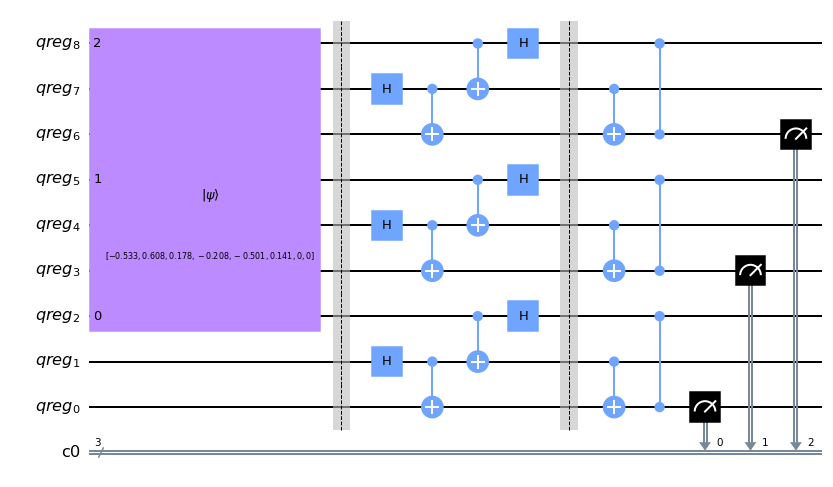

In [3]:
n = 3
positionMax = 1000
positions = prepareRandomSatellitePositions(n,positionMax)

qc = teleportation(positions)
states = positions/np.linalg.norm(positions)

display(qc.draw(output='mpl',reverse_bits=True))


Let's verify that we have successfully teleported the qubits using this circuit.

In [4]:
nShots = 1000
job = execute(qc,Aer.get_backend('qasm_simulator'),shots=nShots)
counts = job.result().get_counts(qc)

print("State\tAmplitude\tProbability\tPrediction\tCounts")
for key in counts:
    print("{:}\t{:.3f}\t\t{:.3f}\t\t{:}\t\t{:}".format(key,states[int(key,2)],states[int(key,2)]**2, int(nShots*states[int(key,2)]**2), counts[key]))


State	Amplitude	Probability	Prediction	Counts
011	-0.208		0.043		43		43
100	-0.501		0.251		251		263
101	0.141		0.020		19		17
001	0.608		0.370		369		359
000	-0.533		0.284		283		279
010	0.178		0.032		31		39


<div class="alert alert-block alert-success">
<b></b> The algorithm works.
</div>

<h2 align="left" style="color: #cd7f32;">HHL algorithm for n satellites</h2>
We redefine here the functions used for finding the orbit of one satellite in order to obtaion the solution for the general case of n satellites.


In [6]:
import numpy as np

from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import Statevector

import matplotlib.pyplot as plt



def quantumSolve(matrix, vector):
    """
    This function uses HHL algorothm to compute the solution of the equation Matrix * X = Vector and returns the solution
    
    Input:
    - matrix : The matrix r"presenting the linear system
    - vector : The vector representing the second memebr of the equation
    
    Output
    - Solution X of the equation Matrix * X = Vector
    """

    solution = HHL().solve(matrix, vector)
    sv = Statevector(solution.state).data
    

    # Extract the right vector components.
    nqs = int(np.log2(len(vector)))#number of digits representing satellites
    nqt = len(solution.state.qubits) #total number of digits representing the state of the circuit
    # 1 rotaion digit + 2n auxilary digits(each eigen value in one bit) + n satellites digits
    full_vector = np.array([sv[2**(nqt-1)+i] for i in range(2**nqs)])

    full_vector = np.real(full_vector)

    if nqs >= 2:#This is to correct a bug in HHL Qiskit (inversing the sign of the solution)
        full_vector *=-1
    return solution.euclidean_norm*full_vector/np.linalg.norm(full_vector)

def prepare_vector(vector):
    """
    This function prepares a vector representing the uniform superposition of of each satellite position.
    This means that the probability for each satelite x^2+y^2 is uniform and equal to 1/n
    
    Parameter:
    vector : vector representation of the position of the satellites (x1,y1,x2,y2,...,xn,yn)
    
    Output:
    vector : valid quantum state representing the system with equal contribution from all satellites
    """
    nsats = len(vector)//2
    p = int(np.ceil(np.log2(4*nsats)))
    norms  = [np.sqrt((vector[2*i]**2+vector[2*i+1]**2)*nsats) for i in range(nsats)]# normalize each position the normalize all component by deviding by sqrt(nsats)
    vector = [vector[i]/norms[i//2] for i in range(2*nsats)]
    zeros  = np.zeros(2**p-2*nsats)
    vector = np.concatenate((vector,zeros))
    return vector

def orbite_matrix(T, deltaT):
    """
    This function generates the matrix representing the motion of one satellite and its corresponding quantum state vector given the following parameters:
    
    Parameters:
    - T      : List of the periods of the satellites
    - deltaT : The time step
    
    Output :
    - matrix : Hermitian matrix of the system
    """
    
    nsats = len(T)

    x = [2*np.pi*deltaT/T[i] for i in range(nsats)]
    unit_matrices = [np.array([[ 1  , x[i]],[ -x[i] , 1]]) for i in range(nsats)]
    zeros = np.zeros(2)
    zeros = np.block([[zeros],[zeros]])
    
    A = [[zeros for i in range(nsats)] for j in range(nsats)]
    for i in range(nsats):
        A[i][i]=unit_matrices[i]
        A[i] = np.block([A[i]])
    A = np.block([[A[i]] for i in range(nsats)])
    
    p = int(np.ceil(np.log2(2*nsats)))
    if p > int(np.log2(2*nsats)):
        zerosBotom = np.zeros((2**p-2*nsats)*2*nsats).reshape((2**p-2*nsats, 2*nsats))
        zerosTop   = np.zeros((2**p-2*nsats)*2*nsats).reshape((2*nsats, 2**p-2*nsats))
        zerosDiag  = np.zeros((2**p-2*nsats)*(2**p-2*nsats)).reshape((2**p-2*nsats, 2**p-2*nsats))
        A = np.block([
            [A    , zerosTop ],
            [zerosBotom, zerosDiag]
        ])
    
    zeros = np.zeros(len(A)**2).reshape((len(A),len(A)))
    matrix = np.block([
        [zeros           , A],
        [np.transpose(A), zeros]
    ])# the use transpose instead of hermitian conjugate is sufficient since A is real

    return matrix

def compute_orbite(T, deltaT, P, tend):
    """
    This function computes and plots the orbit of n stellites given the following parameters:
    
    Input:
    - T      : List of the periods of the satellites
    - deltaT : The time step
    - P      : List of initial positions : (x1,y1,x2,y2, ,xn,yn)
    - tEnd   : Time when the simulation ends
    
    Output:
    - None
    """
    
    nsats = len(T)
    X = [[P[2*i]] for i in range(nsats)]
    Y = [[P[2*i+1]] for i in range(nsats)]
    r = [np.sqrt(P[2*i]**2+P[2*i+1]**2) for i in range(nsats)]
    matrix = orbite_matrix(T, deltaT)
    vector = prepare_vector(P)
    n = len(vector)//2
    flag = True # Flag used to set up the tolerance required for the condition of quiting the loop
    print("Step\tOutput vector\n")
    print(0,"\t",np.round(vector,3))
    t = 0
    
    while t<tEnd:
        t += deltaT
        vector = quantumSolve(matrix, vector)
        # Prepare entery for next iteration
        vector = vector[n:]
        #adding current solution to solution list
        for i in range(nsats):
            X[i].append(vector[2*i]*r[i]*np.sqrt(nsats))
            Y[i].append(vector[2*i+1]*r[i]*np.sqrt(nsats))
        vector = prepare_vector(vector)
        
        print(len(X[0])-1,"\t",np.round(vector,3))
        
    # Plotting the results
    print("Dotted line -> Finish position")
    print("Solid line  -> Finish position\n")
    for i in range(nsats):
        color = (randrange(100)/100,randrange(100)/100,randrange(100)/100)
        plt.plot(X[i], Y[i], 'o')
        plt.plot([0,X[i][0]], [0,Y[i][0]],linestyle = 'dotted')#Start position
        plt.plot([0,X[i][-1]], [0,Y[i][-1]])#Finish position
        plt.xlabel('X{}'.format(i+1))
        plt.ylabel('Y{}'.format(i+1))
        plt.title('Satellite {}'.format(i+1))
        plt.axis('equal')
        plt.show()


<h3 align="left" style="color: #cd7f32;">Example 1: two satellites</h3>

Step	Output vector

0 	 [0.382 0.595 0.    0.707 0.    0.    0.    0.   ]
1 	 [ 0.35   0.614 -0.11   0.699  0.     0.     0.     0.   ]
2 	 [ 0.318  0.632 -0.217  0.673  0.     0.     0.     0.   ]
3 	 [ 0.284  0.647 -0.319  0.631  0.     0.     0.     0.   ]
4 	 [ 0.25   0.661 -0.413  0.574  0.     0.     0.     0.   ]
5 	 [ 0.215  0.674 -0.497  0.503  0.     0.     0.     0.   ]
6 	 [ 0.18   0.684 -0.569  0.42   0.     0.     0.     0.   ]
7 	 [ 0.144  0.692 -0.627  0.327  0.     0.     0.     0.   ]
8 	 [ 0.107  0.699 -0.67   0.225  0.     0.     0.     0.   ]
9 	 [ 0.071  0.704 -0.697  0.119  0.     0.     0.     0.   ]
10 	 [ 0.034  0.706 -0.707  0.009  0.     0.     0.     0.   ]
11 	 [-0.003  0.707 -0.7   -0.101  0.     0.     0.     0.   ]
Dotted line -> Finish position
Solid line  -> Finish position



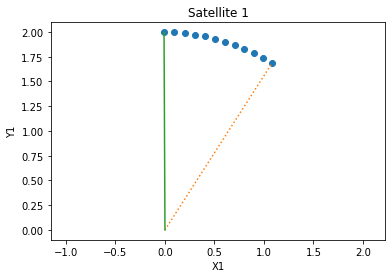

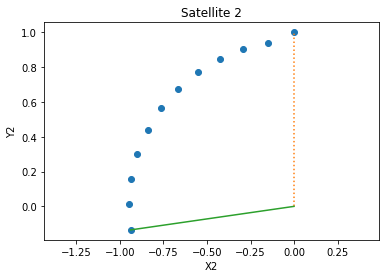

In [6]:
T =[3,1]
deltaT = min(T)/40
P = [2*np.cos(1),2*np.sin(1),0,1]
tEnd = min(T)/4

compute_orbite(T, deltaT, P,tEnd)

<h3 align="left" style="color: #cd7f32;">Example 2: 4 satellites</h3>

Step	Output vector

0 	 [0.447 0.224 0.    0.5   0.    0.5   0.    0.5   0.    0.    0.    0.
 0.    0.    0.    0.   ]
1 	 [ 0.438  0.241 -0.013  0.5   -0.039  0.498 -0.078  0.494  0.     0.
  0.     0.     0.     0.     0.     0.   ]
2 	 [ 0.428  0.258 -0.026  0.499 -0.078  0.494 -0.153  0.476  0.     0.
  0.     0.     0.     0.     0.     0.   ]
3 	 [ 0.418  0.275 -0.039  0.498 -0.116  0.486 -0.225  0.446  0.     0.
  0.     0.     0.     0.     0.     0.   ]
4 	 [ 0.407  0.291 -0.052  0.497 -0.154  0.476 -0.292  0.406  0.     0.
  0.     0.     0.     0.     0.     0.   ]
5 	 [ 0.395  0.307 -0.065  0.496 -0.191  0.462 -0.351  0.356  0.     0.
  0.     0.     0.     0.     0.     0.   ]
Dotted line -> Finish position
Solid line  -> Finish position



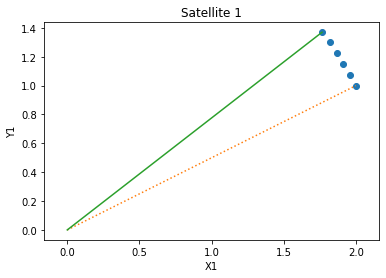

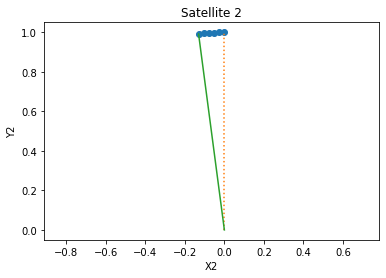

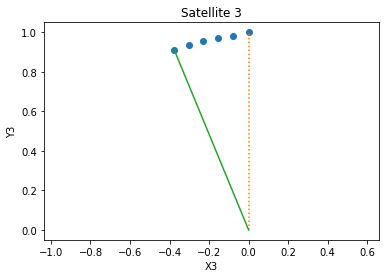

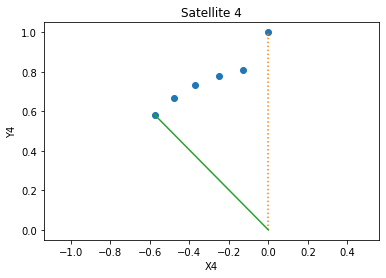

In [7]:
T =[2,3,1,0.5]
deltaT = min(T)/40
P = [2,1,0,1,0,1,0,1]
tEnd = 5*deltaT

compute_orbite(T, deltaT, P,tEnd)


<div class="alert alert-block alert-warning">
Due to some bugs in the qiskit implementation of HHL algorithm:
</br>
- I havn't been able to similate the case of 3 satellites: "cannot convert float infinity to integer"
</br>
- I needed to correct the sign of the output vector when tne number of qubits representing the state exceeds 3.
</div>


<h2 align="left" style="color: #cd7f32;">Final circuit: Quantum sensing + Teleportation + HHL for n satellites</h2>
<h3 align="left" style="color: #cd7f32;">Circuit</h3>
Here is an example of combining the teleportation circuit with the HHL circuit.

In [138]:
def CompleteCircuit(T,positionMax,deltaT):
    """
    This function creates a circuit representing the assembly of the teleportation, HHL and Sensor circuits
    
    Input :
    - T : List of the periods of the satellites
    - positionMax : The maximum position atteignable by a satellite
    - deltaT : Time step of the simulation
    
    Output :
    - qc : Quantum circut of the sensor, Teleportation and HHL
    - matrix : The hermitian matrix of the system
    - positions : The positions of satellites
    """
    n = len(T)
    # Preparing the matrix and sensing the states
    matrix = orbite_matrix(T, deltaT)
    positions = prepareRandomSatellitePositions(n,positionMax)
    zeros = np.zeros(len(positions))
    positions = np.concatenate((positions, zeros))
    vector = positions/np.linalg.norm(positions)    

    #Preparing Teleportation and HHL circuit
    teleportation_circuit = teleportation(vector[:len(vector)//2])
    hhl_circuit = HHL().construct_circuit(matrix, vector)

    #Determining the size of the system
    nstates = int(np.log2(len(vector)))
    size = len(teleportation_circuit.qubits)+len(hhl_circuit.qubits)-nstates+1
    teleportation_cl = len(teleportation_circuit.clbits)

    # Preparing the final Quantum circuit
    q  = QuantumRegister(size)
    c  = ClassicalRegister(teleportation_cl+2)
    qc = QuantumCircuit(q,c)

    # Adding teleportation circuit to the final circuit
    qc = qc.compose(teleportation_circuit,range(len(teleportation_circuit.qubits)))

    # Adding HHL circuit to the final circuit: nsates qubits are common with teleportation
    wiring_1 = [3*i for i in range(nstates-1)]
    wiring_2 = [i for i in range(len(teleportation_circuit.qubits),size)]
    wiring = wiring_1+wiring_2
    qc = qc.compose(hhl_circuit,wiring)

    return qc, matrix, positions


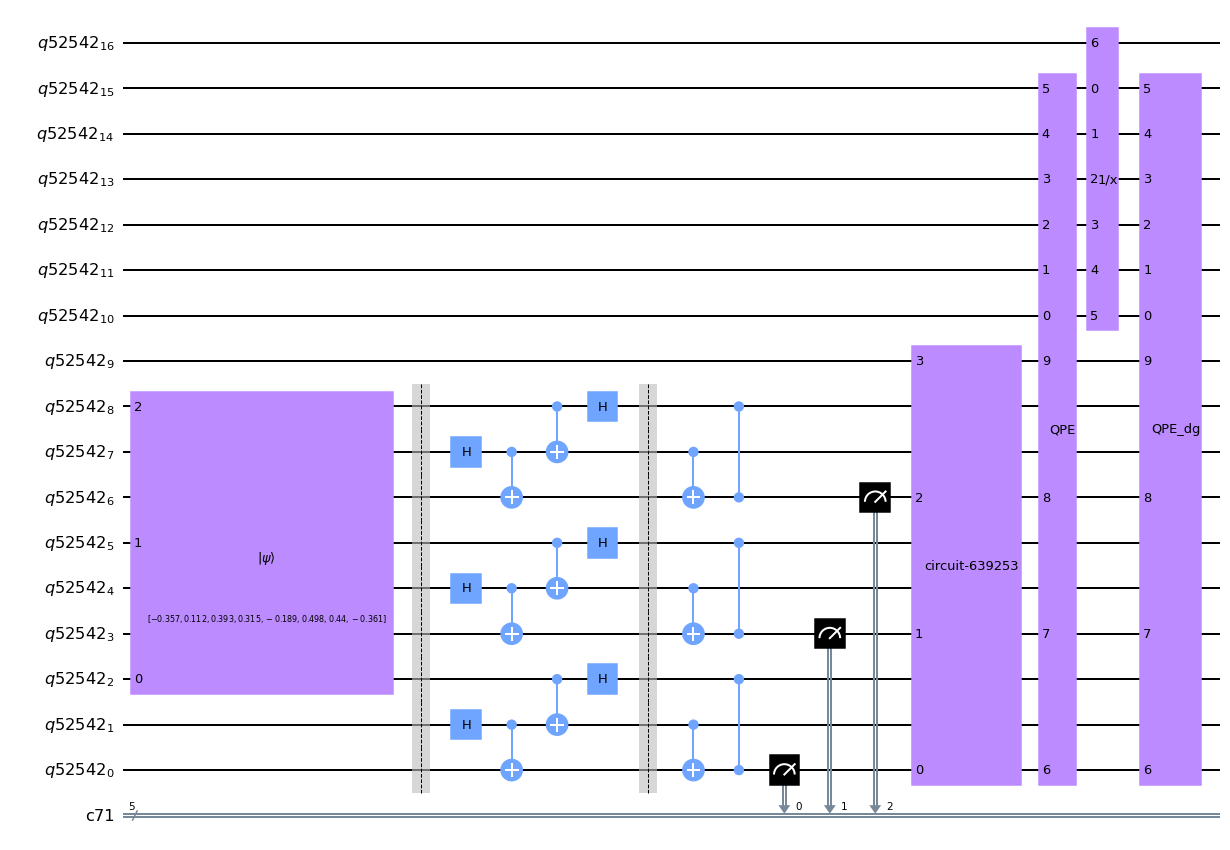

In [100]:
positionMax = 1000
T = [1,2,3,1]
deltaT = min(T)/30

qc = CompleteCircuit(T,positionMax,deltaT)[0]

display(qc.draw(output='mpl',reverse_bits=True))
